## Server behaviours in healthcare

![alt text](bin/Server_behaviours_paper_distribution.png "Servers")

### Data:
- $n = 4832$
- Data from one shift (8am - 4pm)
- Data for urget patients (this category has the most number of attendees)

### Service rate \& workoload:
- Low workload levels to moderate - Service times decrease
- Moderate to high workload levels - Service times stabilise
- Moderate to low workload levels - Service times increase

### Two-speed model:

- **Number of servers**: C = 1
- **Arrival rate**: $λ = 1 / 92$
- **Service rate**: $μ_1 = 1/86, \quad μ_2 = 1/62$
- **Two-speed model**: 
$$
μ = μ_1 \text{ if queue size } < 7 \\
μ = μ_2 \text{ if queue size } \geq 7
$$

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np

import ambulance_game as abg

## Apply two-speed model logic

In [2]:
arrival_rate = 1 / 92
service_rate_1 = 1 / 86
service_rate_2 = 1 / 62

In [3]:
lambda_2 = 0            # No ambulance arrivals

lambda_1 = 1 / 92       # Other individuals arrival rate
num_of_servers = 1      # Number of servers (doctors)
threshold=float('inf')  # No need for threshold since λ_2 = 0 
system_capacity = 100   # artificial system capacity
buffer_capacity = 100   # artificial buffer capacity

target = 2

In [4]:
rates = {}
for server in range(1, num_of_servers + 1):
    rates[server] = {}
    for u in range(buffer_capacity + 1):
        for v in range(system_capacity + 1):
            mu = service_rate_1 if v < 7 else service_rate_2
            rates[server][(u, v)] = mu

#### Find values for system_capacity (hospital servers + waiting space) and buffer_capacity (parking space)

In [141]:
Qs = abg.simulation.simulate_model(
    lambda_1=lambda_1, 
    lambda_2=lambda_2, 
    mu=rates, 
    num_of_servers=num_of_servers, 
    threshold=threshold, 
    system_capacity=float('inf'), 
    buffer_capacity=float('inf'),
    runtime=100000,
    num_of_trials=100,
    seed_num=0,
)
if type(Qs) is not list:
    Qs = [Qs]
print("Max number of people in the model:", max([max([v for (_, v) in Q.statetracker.state_probabilities().keys()]) for Q in Qs]))

Max number of people in the model: 30


## Service rates
Set the service rates such that for all states $(u,v)$:
$$
μ = μ_1 \text{ if } v < 7 \\
μ = μ_2 \text{ if } v \geq 7
$$

In [5]:
system_capapcity = 35
buffer_capacity = 1

rates = {}
for server in range(1, num_of_servers + 1):
    rates[server] = {}
    for u in range(buffer_capacity + 1):
        for v in range(system_capacity + 1):
            mu = service_rate_1 if v < 7 else service_rate_2
            rates[server][(u, v)] = mu

In [7]:
Q = abg.simulation.simulate_model(
    lambda_1=lambda_1, 
    lambda_2=lambda_2, 
    mu=rates, 
    num_of_servers=num_of_servers, 
    threshold=threshold, 
    system_capacity=system_capacity, 
    buffer_capacity=buffer_capacity,
    runtime=100000,
    num_of_trials=100,
    seed_num=0,
)
if type(Q) is not list:
    Q = [Q]

In [8]:
all_sim_recs = [sim.get_all_records() for sim in Q]
mean_wait = np.mean([np.mean([r.waiting_time for r in recs if r.arrival_date > 100 and r.node == 2]) for recs in all_sim_recs])
mean_wait

307.0772905561477

## Modified model for ambulances

- Set a parameter $p$ for ambualnce proportion s.t. $λ_2 = p × Λ, \quad λ_1 = (1-p) × Λ$
- Also divide the general service rate among the number of servers we have

In [9]:
ambulance_proportion = 0.6
arrival_rate = 1 / 92

service_rate_1 = 1 / 86
service_rate_2 = 1 / 62

In [10]:
num_of_servers = 4
arrival_rate = num_of_servers * arrival_rate

lambda_2 = ambulance_proportion * arrival_rate
lambda_1 = (1 - ambulance_proportion) * arrival_rate

threshold = 10
system_capapcity = 35
buffer_capacity = 20

In [11]:
rates = {}
for server in range(1, num_of_servers + 1):
    rates[server] = {}
    for u in range(buffer_capacity + 1):
        for v in range(system_capacity + 1):
            mu = service_rate_1 if (u + v) < 7 else service_rate_2
            rates[server][(u, v)] = mu

## Team make-up
Team characteristics = (*Experienced*, *Moderate*, *Moderate*, *Intern*)

In [12]:
def random_prioirity(srv, ind):
    if srv.id_number == 1:  # Assign patient to Experienced if available
        return 0
    if srv.id_number == 2:  # Assign patient to Intern only if everyone else is unavailable
        return 1
    return random.random()

# Make server 1 slightly faster
for u in range(buffer_capacity + 1):
    for v in range(system_capapcity + 1):
        rates[1][(u, v)] = rates[1][(u, v)] * 1.2

# Make server 2 slightly slower
for u in range(buffer_capacity + 1):
    for v in range(system_capapcity + 1):
        rates[2][(u, v)] = rates[2][(u, v)] * 0.8

## Run simulation

In [13]:
# random.seed(11)
runtime=100000
Q = abg.simulation.simulate_model(
    lambda_1=lambda_1, 
    lambda_2=lambda_2, 
    mu=rates, 
    num_of_servers=num_of_servers, 
    threshold=threshold, 
    system_capacity=system_capacity, 
    buffer_capacity=buffer_capacity,
    runtime=runtime,
    num_of_trials=1,
    seed_num=0,
    server_priority_function=random_prioirity,
)

## Useful outputs

In [47]:
# Utilisation
all_utilisations = [util / Q.current_time for util in Q.nodes[2].all_servers_busy]

# Proportion of individuals served
all_individuals = len(Q.nodes[-1].all_individuals)
served_proportions = [len(srv.served_inds) / all_individuals for srv in Q.nodes[2].servers]

# Mean service times
service_times = [np.mean(srv.service_times) for srv in Q.nodes[2].servers]

In [48]:
print("Id\t Utilisation\t Prop. Served\t Service time")
for index, server in enumerate(Q.nodes[2].servers):
    print(server.id_number, "\t", round(100 * all_utilisations[index], 3), "\t", round(100 * served_proportions[index], 3), "\t", round(service_times[index], 3))

Id	 Utilisation	 Prop. Served	 Service time
1 	 87.233 	 33.089 	 62.444
2 	 78.441 	 18.154 	 102.296
3 	 82.507 	 24.568 	 79.555
4 	 83.546 	 24.284 	 81.506


## Utility function 1

$$
U_k = e (\text{\# served}) + (1-e) (\text{idle time})
$$

In [34]:
def utility_function_1(Q, server, rates, e_parameter=0.5):
    individuals = len(server.served_inds)
    idle_time = Q.current_time - server.busy_time
    return e_parameter * individuals + (1 - e_parameter) * idle_time

In [35]:
A = np.zeros((4,11))
print("\t\t\tIdle time ---------------------------------------------------------------- Served inds")
print("\t\t\t e=0\te=0.1\te=0.2\te=0.3\te=0.4\te=0.5\te=0.6\te=0.7\te=0.8\te=0.9\t e=1")
print("\t\t\t=======================================================================================")
for server in Q.nodes[2].servers:
    print(f"Server {server.id_number} utilities:", end="")
    for e_par in np.linspace(0, 1, 11):
        print(f"\t{round(utility_function_1(Q, server, rates, e_parameter=e_par), 1)}", end="")
        A[server.id_number - 1, int(e_par * 10)] = utility_function_1(Q, server, rates, e_parameter=e_par)
    print(" ")

			Idle time ---------------------------------------------------------------- Served inds
			 e=0	e=0.1	e=0.2	e=0.3	e=0.4	e=0.5	e=0.6	e=0.7	e=0.8	e=0.9	 e=1
Server 1 utilities:	12767.9	11631.0	10494.0	9357.0	8220.0	7083.0	5946.0	4809.0	3672.0	2535.0	1398.0 
Server 2 utilities:	21561.6	19482.2	17402.7	15323.3	13243.8	11164.3	9084.9	7005.4	4925.9	2846.5	767.0 
Server 3 utilities:	17495.3	15849.5	14203.8	12558.1	10912.4	9266.6	7620.9	5975.2	4329.5	2683.7	1038.0 
Server 4 utilities:	16455.6	14912.6	13369.7	11826.7	10283.8	8740.8	7197.8	5654.9	4111.9	2569.0	1026.0 


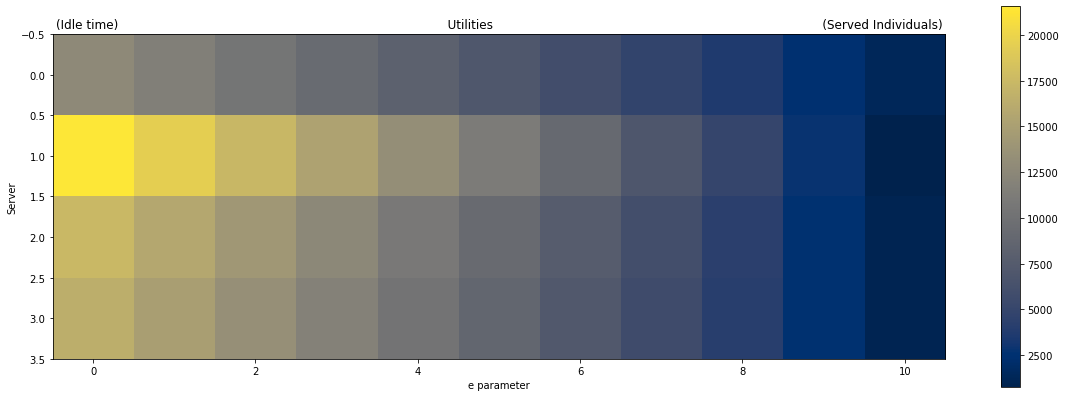

In [36]:
plt.figure(figsize=(20, 7))
plt.imshow(A, cmap="cividis")
plt.title("(Idle time)" + 85 * " " + "Utilities" + 85 * " " + "(Served Individuals)")
plt.ylabel("Server")
plt.xlabel("e parameter")
plt.colorbar()

## Utility function 2
$$
    U_k = e \frac{\text{\# served}}{\text{\# all individuals}} + (1 - e) \frac{\text{current time - busy time}}{\text{current time}}
$$

In [37]:
def utility_function_2(Q, server, rates, e_parameter=0.5):
    individuals = len(server.served_inds) / len(Q.nodes[-1].all_individuals)
    idle_prop = (Q.current_time - server.busy_time) / Q.current_time
    return e_parameter * individuals + (1 - e_parameter) * idle_prop

In [38]:
B = np.zeros((4,11))
print("\t\t\tIdle time ---------------------------------------------------------------- Served inds")
print("\t\t\t  e=0\te=0.1\te=0.2\te=0.3\te=0.4\te=0.5\te=0.6\te=0.7\te=0.8\te=0.9\t e=1")
print("\t\t\t=======================================================================================")
for server in Q.nodes[2].servers:
    print(f"Server {server.id_number} utilities:", end="")
    for e_par in np.linspace(0, 1, 11):
        print(f"\t{round(utility_function_2(Q, server, rates, e_parameter=e_par), 4)}", end="")
        B[server.id_number - 1, int(e_par * 10)] = utility_function_2(Q, server, rates, e_parameter=e_par)
    print(" ")

			Idle time ---------------------------------------------------------------- Served inds
			  e=0	e=0.1	e=0.2	e=0.3	e=0.4	e=0.5	e=0.6	e=0.7	e=0.8	e=0.9	 e=1
Server 1 utilities:	0.1277	0.148	0.1683	0.1886	0.209	0.2293	0.2496	0.2699	0.2902	0.3106	0.3309 
Server 2 utilities:	0.2156	0.2122	0.2088	0.2054	0.202	0.1986	0.1952	0.1918	0.1883	0.1849	0.1815 
Server 3 utilities:	0.1749	0.182	0.1891	0.1962	0.2032	0.2103	0.2174	0.2245	0.2315	0.2386	0.2457 
Server 4 utilities:	0.1645	0.1724	0.1802	0.188	0.1959	0.2037	0.2115	0.2193	0.2272	0.235	0.2428 


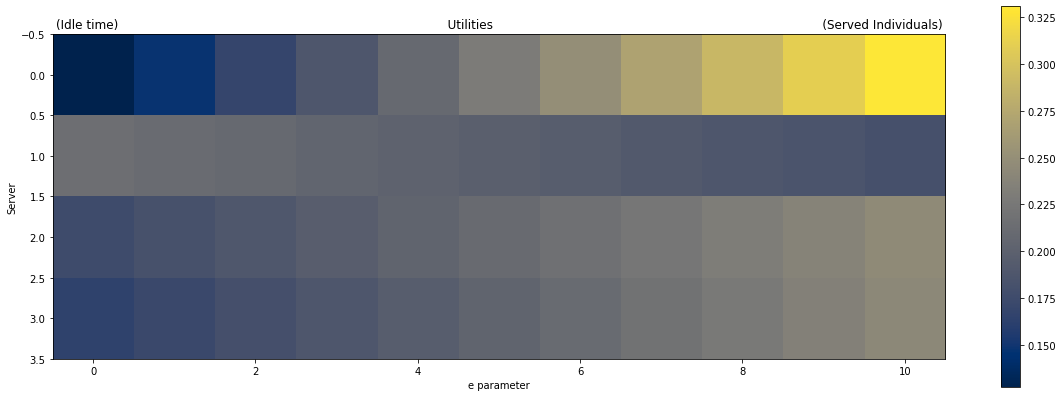

In [39]:
plt.figure(figsize=(20, 7))
plt.imshow(B, cmap="cividis")
plt.title("(Idle time)" + 85 * " " + "Utilities" + 85 * " " + "(Served Individuals)")
plt.ylabel("Server")
plt.xlabel("e parameter")
plt.colorbar()

## Utility function 3
$$
    U_k = e (\text{mean service time})_k + (1 - e) (\text{idle time})_k
$$

In [83]:
def utility_function_3(Q, server, rates, e_parameter=0.5):
    server_rates = np.mean(server.service_times)
    idle_time = (Q.current_time - server.busy_time) / Q.current_time
    return e_parameter * server_rates + (1 - e_parameter) * idle_time

In [86]:
C = np.zeros((4,11))
print("\t\t\tIdle time ---------------------------------------------------------------- Service time")
print("\t\t\t  e=0\te=0.1\te=0.2\te=0.3\te=0.4\te=0.5\te=0.6\te=0.7\te=0.8\te=0.9\t e=1")
print("\t\t\t=======================================================================================")
for server in Q.nodes[2].servers:
    print(f"Server {server.id_number} utilities:", end="")
    for e_par in np.linspace(0, 1, 11):
        print(f"\t{round(utility_function_3(Q, server, rates, e_parameter=e_par), 4)}", end="")
        C[server.id_number - 1, int(e_par * 10)] = utility_function_3(Q, server, rates, e_parameter=e_par)
    print(" ")

			Idle time ---------------------------------------------------------------- Service time
			  e=0	e=0.1	e=0.2	e=0.3	e=0.4	e=0.5	e=0.6	e=0.7	e=0.8	e=0.9	 e=1
Server 1 utilities:	0.1277	6.3593	12.591	18.8227	25.0543	31.286	37.5176	43.7493	49.981	56.2126	62.4443 
Server 2 utilities:	0.2156	10.4236	20.6316	30.8396	41.0476	51.2555	61.4635	71.6715	81.8795	92.0875	102.2955 
Server 3 utilities:	0.1749	8.113	16.051	23.9891	31.9271	39.8652	47.8032	55.7413	63.6794	71.6174	79.5555 
Server 4 utilities:	0.1645	8.2987	16.4328	24.567	32.7011	40.8353	48.9694	57.1035	65.2377	73.3718	81.506 


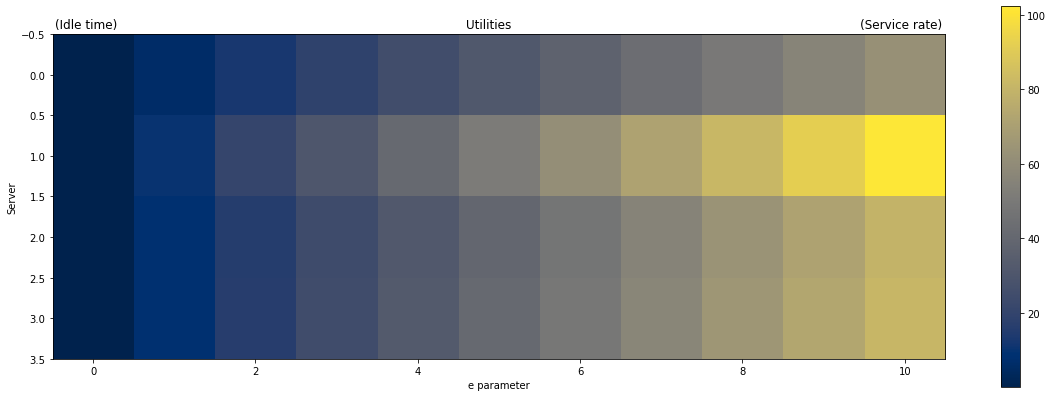

In [85]:
plt.figure(figsize=(20, 7))
plt.imshow(C, cmap="cividis")
plt.title("(Idle time)" + 90 * " " + "Utilities" + 90 * " " + "(Service rate)")
plt.ylabel("Server")
plt.xlabel("e parameter")
plt.colorbar()

## Utility function 4
$$
    U_k = e (\frac{1}{\text{mean service time}_k}) + (1 - e) (\text{idle time})_k
$$

In [94]:
def utility_function_4(Q, server, rates, e_parameter=0.5):
    server_rates = 1 / np.mean(server.service_times)
    idle_time = (Q.current_time - server.busy_time) / Q.current_time
    return e_parameter * server_rates + (1 - e_parameter) * idle_time

In [96]:
C = np.zeros((4,11))
print("\t\t\tIdle time ---------------------------------------------------------------- -Service time")
print("\t\t\t  e=0\te=0.1\te=0.2\te=0.3\te=0.4\te=0.5\te=0.6\te=0.7\te=0.8\te=0.9\t e=1")
print("\t\t\t=======================================================================================")
for server in Q.nodes[2].servers:
    print(f"Server {server.id_number} utilities:", end="")
    for e_par in np.linspace(0, 1, 11):
        print(f"\t{round(utility_function_3(Q, server, rates, e_parameter=e_par), 4)}", end="")
        C[server.id_number - 1, int(e_par * 10)] = utility_function_4(Q, server, rates, e_parameter=e_par)
    print(" ")

			Idle time ---------------------------------------------------------------- -Service time
			  e=0	e=0.1	e=0.2	e=0.3	e=0.4	e=0.5	e=0.6	e=0.7	e=0.8	e=0.9	 e=1
Server 1 utilities:	0.1277	6.3593	12.591	18.8227	25.0543	31.286	37.5176	43.7493	49.981	56.2126	62.4443 
Server 2 utilities:	0.2156	10.4236	20.6316	30.8396	41.0476	51.2555	61.4635	71.6715	81.8795	92.0875	102.2955 
Server 3 utilities:	0.1749	8.113	16.051	23.9891	31.9271	39.8652	47.8032	55.7413	63.6794	71.6174	79.5555 
Server 4 utilities:	0.1645	8.2987	16.4328	24.567	32.7011	40.8353	48.9694	57.1035	65.2377	73.3718	81.506 


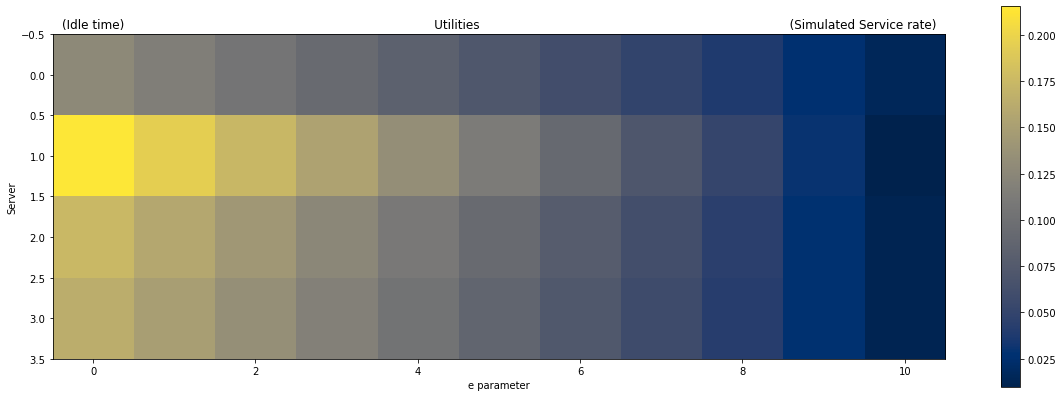

In [97]:
plt.figure(figsize=(20, 7))
plt.imshow(C, cmap="cividis")
plt.title("(Idle time)" + 80 * " " + "Utilities" + 80 * " " + "(Simulated Service rate)")
plt.ylabel("Server")
plt.xlabel("e parameter")
plt.colorbar()